<a href="https://colab.research.google.com/github/hari2578/Delivery_Bike_Car_pytorch/blob/main/Identifying_Key_Entities_in_Recipe_Data_Hari_Vittal_Mahendrakar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [1]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

#### **1.2** Import necessary libraries

In [2]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:

# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [4]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [5]:
# define a function to load json file to a dataframe
def load_json_to_df(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    df = pd.json_normalize(data)
    return df

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [6]:
# read the json file by giving the file path and create a dataframe
json_file_path = "ingredient_and_quantity.json"
df = load_json_to_df(json_file_path )

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [7]:
# display first five rows of the dataframe - df
df.head(5)

,input,pos
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4,1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient unit ingredient


In [8]:
# print the dimensions of dataframe - df
print("DataFrame dimensions:", df.shape)


DataFrame dimensions: (285, 2)


In [9]:
# print the information of the dataframe
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [10]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
df["input_tokens"] = df["input"].apply(lambda x: x.split())
# Tokenize POS
df["pos_tokens"]   = df["pos"].apply(lambda x: x.split())



In [11]:
# display first five rows of the dataframe - df
df.head(5)


,input,pos,input_tokens,pos_tokens
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]"
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]"
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient qua

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [12]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

df.head()

,input,pos,input_tokens,pos_tokens,input_length,pos_length
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31,31
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]",34,34
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]",37,37
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient

In [13]:
# check for the equality of input_length and pos_length in the dataframe

df["length_match"] = df["input_length"] == df["pos_length"]

# Display how many mismatches exist
print("Number of rows where lengths do NOT match:",(~df["length_match"]).sum())

# Show the first few mismatched rows (if any)
df[df["length_match"] == False].head()


Number of rows where lengths do NOT match: 5


,input,pos,input_tokens,pos_tokens,input_length,pos_length,length_match
17,2 cups curd 1 cup gourd cucumber green cor coriander 1/2 teaspoon cumin powder salt,quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient,"[2, cups, curd, 1, cup, gourd, cucumber, green, cor, coriander, 1/2, teaspoon, cumin, powder, salt]","[quantity, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]",15,14,False
27,1 Baguette sliced 1 1/2 tablespoon Butter 1/2 Garlic minced cup Spinach Leaves Palak Red Bell pepper Capsicum Tomato finely chopped Onion Black powder Italian seasoning teaspoon Fresh cream Cheddar cheese grated Salt Roasted tomato pasta sauce,quantity ingredient ingredient quantity unit ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[1, Baguette, sliced, 1, 1/2, tablespoon, Butter, 1/2, Garlic, minced, cup, Spinach, Leaves, Palak, Red, Bell, pepper, Capsicum, Tomato, finely, chopped, Onion, Black, powder, Italian, seasoning, teaspoon, Fresh, cream, Cheddar, cheese, grated, Salt, Roasted, tomato, pasta, sauce]","[quantity, ingredient, ingredient, quantity, unit, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",37,36,False
79,1/2 cup Poha Flattened rice 2 tablespoons Rice flour 2 1/2 liter Milk 1 Nolen Gur or brown sugar Cardamom Elaichi Pods/Seeds 8-10 Mixed nuts almonds/cashews tablespoon Raisins pinch Saffron strands and a little more for garnish Salt,quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient quantity unit ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[1/2, cup, Poha, Flattened, rice, 2, tablespoons, Rice, flour, 2, 1/2, liter, Milk, 1, Nolen, Gur, or, brown, sugar, Cardamom, Elaichi, Pods/Seeds, 8-10, Mixed, nuts, almonds/cashews, tablespoon, Raisins, pinch, Saffron, strands, and, a, little, more, for, garnish, Salt]","[quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, unit, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",38,37,False
164,1/2 cup All Purpose Flour Maida Whole Wheat 1/4 Hung Curd Greek Yogurt 250 grams Chicken minced 1 Spinach Leaves Palak finely chopped Onion 4 cloves Garlic Tomatoes tablespoon Cumin powder Jeera Coriander Powder Dhania 1 1/2 teaspoon Paprika Black pepper 3 sprig Mint Pudina 10 Spring Bulb & Greens 100 Feta Cheese crumbled,quantity unit ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity ingr

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [14]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it

def unique_labels(df):
    """
    Returns a sorted list of all unique POS labels present in the pos_tokens column.

    """
    labels = set()  # to avoid duplicates
    for seq in df["pos_tokens"]:
        labels.update(seq)
    return sorted(labels)

# Get and print the unique labels
unique_pos_labels = unique_labels(df)
print("Unique POS labels:", unique_pos_labels)


Unique POS labels: ['ingredient', 'quantity', 'unit']


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

In [15]:
# Identify rows where input_length and pos_length do not match

rows_to_clean = df[df["input_length"] != df["pos_length"]]

print("Number of rows requiring cleaning:", len(rows_to_clean))
print("Indexes of rows requiring cleaning:")
print(rows_to_clean.index.tolist())

# Display the problematic rows for inspection
rows_to_clean


Number of rows requiring cleaning: 5
Indexes of rows requiring cleaning:
[17, 27, 79, 164, 207]


,input,pos,input_tokens,pos_tokens,input_length,pos_length,length_match
17,2 cups curd 1 cup gourd cucumber green cor coriander 1/2 teaspoon cumin powder salt,quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient,"[2, cups, curd, 1, cup, gourd, cucumber, green, cor, coriander, 1/2, teaspoon, cumin, powder, salt]","[quantity, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]",15,14,False
27,1 Baguette sliced 1 1/2 tablespoon Butter 1/2 Garlic minced cup Spinach Leaves Palak Red Bell pepper Capsicum Tomato finely chopped Onion Black powder Italian seasoning teaspoon Fresh cream Cheddar cheese grated Salt Roasted tomato pasta sauce,quantity ingredient ingredient quantity unit ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[1, Baguette, sliced, 1, 1/2, tablespoon, Butter, 1/2, Garlic, minced, cup, Spinach, Leaves, Palak, Red, Bell, pepper, Capsicum, Tomato, finely, chopped, Onion, Black, powder, Italian, seasoning, teaspoon, Fresh, cream, Cheddar, cheese, grated, Salt, Roasted, tomato, pasta, sauce]","[quantity, ingredient, ingredient, quantity, unit, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",37,36,False
79,1/2 cup Poha Flattened rice 2 tablespoons Rice flour 2 1/2 liter Milk 1 Nolen Gur or brown sugar Cardamom Elaichi Pods/Seeds 8-10 Mixed nuts almonds/cashews tablespoon Raisins pinch Saffron strands and a little more for garnish Salt,quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient quantity unit ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[1/2, cup, Poha, Flattened, rice, 2, tablespoons, Rice, flour, 2, 1/2, liter, Milk, 1, Nolen, Gur, or, brown, sugar, Cardamom, Elaichi, Pods/Seeds, 8-10, Mixed, nuts, almonds/cashews, tablespoon, Raisins, pinch, Saffron, strands, and, a, little, more, for, garnish, Salt]","[quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, unit, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",38,37,False
164,1/2 cup All Purpose Flour Maida Whole Wheat 1/4 Hung Curd Greek Yogurt 250 grams Chicken minced 1 Spinach Leaves Palak finely chopped Onion 4 cloves Garlic Tomatoes tablespoon Cumin powder Jeera Coriander Powder Dhania 1 1/2 teaspoon Paprika Black pepper 3 sprig Mint Pudina 10 Spring Bulb & Greens 100 Feta Cheese crumbled,quantity unit ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity ingr

<font color = red>[write your answer]</font> <br>


##### Data validation revealed 5 rows requiring cleaning due to mismatches between the number of input tokens and POS tags. The affected indexes are 17, 27, 79, 164, and 207. These inconsistencies likely stem from formatting issues such as improper spacing, merged words, or irregular quantity formats. Identifying these rows ensures they can be corrected or removed before model training, improving dataset quality and sequence label alignment.

##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [16]:
# drop the irrelevant recipe data

# 1. Drop rows where input_length and pos_length do not match
df_cleaned = df[df["input_length"] == df["pos_length"]].copy()

# 2. (Optional safety) Drop any rows with missing input or pos values
df_cleaned = df_cleaned.dropna(subset=["input", "pos"])

# Reset index after dropping rows
df_cleaned.reset_index(drop=True, inplace=True)

print("Original number of rows:", len(df))
print("Number of rows after cleaning:", len(df_cleaned))

# Quick check
df_cleaned.head()


Original number of rows: 285
Number of rows after cleaning: 280


,input,pos,input_tokens,pos_tokens,input_length,pos_length,length_match
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31,31,True
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]",34,34,True
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]",37,37,True
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient qu

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [17]:
# update the input and pos length in input_length and pos_length

df_cleaned["input_length"] = df_cleaned["input_tokens"].apply(len)
df_cleaned["pos_length"]   = df_cleaned["pos_tokens"].apply(len)

# Display first few rows to verify the update
df_cleaned.head()


,input,pos,input_tokens,pos_tokens,input_length,pos_length,length_match
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31,31,True
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]",34,34,True
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]",37,37,True
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient qu

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [18]:
# validate the input length and pos length as input_length and pos_length

df_cleaned["length_match"] = df_cleaned["input_length"] == df_cleaned["pos_length"]

# Print validation results
print("Number of rows where lengths match:", df_cleaned["length_match"].sum())
print("Number of rows where lengths do NOT match:", (~df_cleaned["length_match"]).sum())

# Display any problematic rows (should be zero after cleaning)
df_cleaned[df_cleaned["length_match"] == False]


Number of rows where lengths match: 280
Number of rows where lengths do NOT match: 0


,input,pos,input_tokens,pos_tokens,input_length,pos_length,length_match


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [19]:
# split the dataset into training and validation sets

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df_cleaned,
    test_size=0.30,       # 30% validation set
    random_state=42,
    shuffle=True
)

# Reset indexes
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

print("Total cleaned rows :", len(df_cleaned))
print("Training rows (70%) :", len(train_df))
print("Validation rows (30%):", len(val_df))


Total cleaned rows : 280
Training rows (70%) : 196
Validation rows (30%): 84


###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [20]:
# print the first five rows of train_df
train_df.head(5)

,input,pos,input_tokens,pos_tokens,input_length,pos_length,length_match
0,250 grams Okra Oil 1 Onion finely chopped Tomato Grated teaspoon Ginger 2 Garlic Finely 1/2 Cumin seeds 1/4 Teaspoon asafoetida cup cottage cheese pinched coriander powder mango red chilli turmeric,quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient unit ingredient quantity ingredient ingredient quantity ingredient ingredient quantity unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[250, grams, Okra, Oil, 1, Onion, finely, chopped, Tomato, Grated, teaspoon, Ginger, 2, Garlic, Finely, 1/2, Cumin, seeds, 1/4, Teaspoon, asafoetida, cup, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]","[quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31,31,True
1,200 grams Paneer Homemade Cottage Cheese 2 Potato Aloo Bay leaf tej patta Dry Red Chilli 1 tablespoon Panch Phoran Masala roasted and powdered Tomato big sized teaspoon Turmeric powder Haldi Cumin seeds Jeera Ginger grated Salt 1/2 Sugar Sunflower Oil,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient,"[200, grams, Paneer, Homemade, Cottage, Cheese, 2, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, 1, tablespoon, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, teaspoon, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, 1/2, Sugar, Sunflower, Oil]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient]",41,41,True
2,500 grams Cabbage Patta Gobi Muttaikose 1 teaspoon Mustard seeds 1-1/2 White Urad Dal Split sprig Curry leaves Green Chilli 1/4 cup Fresh coconut Salt,quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient,"[500, grams, Cabbage, Patta, Gobi, Muttaikose, 1, teaspoon, Mustard, seeds, 1-1/2, White, Urad, Dal, Split, sprig, Curry, leaves, Green, Chilli, 1/4, cup, Fresh, coconut, Salt]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]",25,25,True
3,500 grams Fresh Figs 1/4 cup Lemon juice 1 teaspoon zest 2 Red Chilli flakes 1/2 Honey Brown Sugar (Demerara Sugar),quantity unit ingredient ingredient quantity unit ingredient ingredient quantity unit ingredient quantity ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient,"[500, grams, Fresh, Figs, 1/4, cup, Lemon, juice, 1, teaspoon, zest, 2, Red, Chilli, flakes, 1/2, Honey, Brown, Sugar, (Demerara, Sugar)]","[quantity, unit, ingredient, ingredient, quantity, unit, ingred

In [21]:
# print the first five rows of the val_df
val_df.head(5)

,input,pos,input_tokens,pos_tokens,input_length,pos_length,length_match
0,1 cup Ada 2 liter Milk 3/4 Sugar tablespoon Ghee 1/2 teaspoon Cardamom Powder Elaichi,quantity unit ingredient quantity unit ingredient quantity ingredient unit ingredient quantity unit ingredient ingredient ingredient,"[1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]","[quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]",15,15,True
1,1 Carrot Gajjar chopped 7 Potatoes Aloo 2 cups Cauliflower gobi cut to small florets Onion tablespoon Ginger Garlic Paste Salt teaspoons Sunflower Oil 1/2 cup Fresh coconut grated teaspoon Whole Black Peppercorns Green Chillies Fennel seeds Saunf Poppy 6 Cashew nuts inch Cinnamon Stick Dalchini Star anise 3 Cloves Laung Cardamom Elaichi Pods/Seeds Cumin Jeera,quantity ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[1, Carrot, Gajjar, chopped, 7, Potatoes, Aloo, 2, cups, Cauliflower, gobi, cut, to, small, florets, Onion, tablespoon, Ginger, Garlic, Paste, Salt, teaspoons, Sunflower, Oil, 1/2, cup, Fresh, coconut, grated, teaspoon, Whole, Black, Peppercorns, Green, Chillies, Fennel, seeds, Saunf, Poppy, 6, Cashew, nuts, inch, Cinnamon, Stick, Dalchini, Star, anise, 3, Cloves, Laung, Cardamom, Elaichi, Pods/Seeds, Cumin, Jeera]","[quantity, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",56,56,True
2,1 tablespoon Sunflower Oil 3 Potato Aloo Ginger paste Green Chilli chopped 1-1/12 tablespoons Sesame seeds Til teaspoon Red powder Cumin Jeera Coriander Powder Dhania 1/2 Garam masala 2 Sweet Chutney Date Tamarind Leaves few,quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient,"[1, tablespoon, Sunflower, Oil, 3, Potato, Aloo, Ginger, paste, Green, Chilli, chopped, 1-1/12, tablespoons, Sesame, seeds, Til, teaspoon, Red, powder, Cumin, Jeera, Coriander, Powder, Dhania, 1/2, Garam, masala, 2, Sweet, Chutney, Date, Tamarind, Leaves, few]","[quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",35,35,True
3,1 cup green peas gram flour 1/2 cheese tsp ginger 2 chillies turmeric powder cumin teaspoon salt oil,quantity unit ingredient ingredient ingredient ingredient quantity ingredient unit ingredient 

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [22]:
# extract the training and validation sets by taking input_tokens and pos_tokens

X_train = train_df["input_tokens"].tolist()
y_train = train_df["pos_tokens"].tolist()

X_val = val_df["input_tokens"].tolist()
y_val = val_df["pos_tokens"].tolist()

# Display sample shapes / lengths for confirmation
print("Training samples :", len(X_train))
print("Validation samples:", len(X_val))

# Print first example to verify structure
print("\nSample X_train[0]:", X_train[0])
print("Sample y_train[0]:", y_train[0])


Training samples : 196
Validation samples: 84

Sample X_train[0]: ['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'teaspoon', 'Ginger', '2', 'Garlic', 'Finely', '1/2', 'Cumin', 'seeds', '1/4', 'Teaspoon', 'asafoetida', 'cup', 'cottage', 'cheese', 'pinched', 'coriander', 'powder', 'mango', 'red', 'chilli', 'turmeric']
Sample y_train[0]: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']


In [23]:
# validate the shape of training and validation samples

print("Number of training input samples :", len(X_train))
print("Number of training label samples :", len(y_train))
print("Number of validation input samples :", len(X_val))
print("Number of validation label samples :", len(y_val))

# Check if all training input and label sequences match in length
train_mismatch = [
    i for i, (x, y) in enumerate(zip(X_train, y_train)) if len(x) != len(y)
]

# Check mismatch in validation set
val_mismatch = [
    i for i, (x, y) in enumerate(zip(X_val, y_val)) if len(x) != len(y)
]

print("\nTraining mismatched sequences :", len(train_mismatch))
print("Validation mismatched sequences :", len(val_mismatch))

# Ideally both should be 0


Number of training input samples : 196
Number of training label samples : 196
Number of validation input samples : 84
Number of validation label samples : 84

Training mismatched sequences : 0
Validation mismatched sequences : 0


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [24]:
# Display the number of unique labels present in y_train

unique_labels = set(label for seq in y_train for label in seq)

print("Unique labels:", unique_labels)
print("Number of unique labels:", len(unique_labels))


Unique labels: {'quantity', 'ingredient', 'unit'}
Number of unique labels: 3


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [25]:
# flatten the list for nested_list (input_tokens, pos_tokens)

# Flatten input tokens
flat_tokens = [token for seq in X_train for token in seq]

# Flatten POS labels
flat_labels = [label for seq in y_train for label in seq]

print("Total tokens in training set:", len(flat_tokens))
print("Total labels in training set:", len(flat_labels))


Total tokens in training set: 7114
Total labels in training set: 7114


In [26]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [27]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens

def extract_and_validate_tokens(df, dataset_name):
    # Flatten input_tokens
    flat_inputs = [token for seq in df["input_tokens"] for token in seq]

    # Flatten pos_tokens
    flat_pos = [label for seq in df["pos_tokens"] for label in seq]

    # Print summary
    print(f"--- {dataset_name} Dataset Summary ---")
    print("Total flattened input tokens :", len(flat_inputs))
    print("Total flattened POS tokens   :", len(flat_pos))
    print("Lengths match?               :", len(flat_inputs) == len(flat_pos))
    print()

    # Display first 10 records with input and pos tokens
    print("First 10 input and POS tag pairs:")
    for i in range(10):
        print(f"Input Tokens[{i}]:", df['input_tokens'].iloc[i])
        print(f"POS Tokens[{i}]  :", df['pos_tokens'].iloc[i])
        print("-" * 50)

    return flat_inputs, flat_pos


# Call the function for training dataset
flat_train_inputs, flat_train_pos = extract_and_validate_tokens(train_df, "Training")


--- Training Dataset Summary ---
Total flattened input tokens : 7114
Total flattened POS tokens   : 7114
Lengths match?               : True

First 10 input and POS tag pairs:
Input Tokens[0]: ['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'teaspoon', 'Ginger', '2', 'Garlic', 'Finely', '1/2', 'Cumin', 'seeds', '1/4', 'Teaspoon', 'asafoetida', 'cup', 'cottage', 'cheese', 'pinched', 'coriander', 'powder', 'mango', 'red', 'chilli', 'turmeric']
POS Tokens[0]  : ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']
--------------------------------------------------
Input Tokens[1]: ['200', 'grams', 'Paneer', 'H

In [28]:
# extract the tokens and its pos tags

# Flatten input_tokens from training set
train_tokens = [token for seq in train_df["input_tokens"] for token in seq]

# Flatten pos_tokens from training set
train_pos_tags = [tag for seq in train_df["pos_tokens"] for tag in seq]

print("Total training tokens   :", len(train_tokens))
print("Total training POS tags :", len(train_pos_tags))

# Validate that both lists have equal length
print("Lengths match? :", len(train_tokens) == len(train_pos_tags))


Total training tokens   : 7114
Total training POS tags : 7114
Lengths match? : True


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [29]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays

def categorize_tokens(tokens, pos_tags):
    # Expected valid labels
    valid_labels = {"ingredient", "unit", "quantity"}

    # Check for unexpected labels
    unique_found = set(pos_tags)
    if not unique_found.issubset(valid_labels):
        print("Unexpected labels found:", unique_found - valid_labels)
        print("Returning empty arrays due to invalid POS tags.")
        return [], [], []

    # Categorized lists
    ingredients = []
    units = []
    quantities = []

    # Categorize tokens
    for token, tag in zip(tokens, pos_tags):
        if tag == "ingredient":
            ingredients.append(token)
        elif tag == "unit":
            units.append(token)
        elif tag == "quantity":
            quantities.append(token)

    return ingredients, units, quantities




In [30]:
#  call the function to categorise the labels into respective list
ingredients_list, units_list, quantities_list = categorize_tokens(train_tokens, train_pos_tags)

print("Ingredients extracted:", len(ingredients_list))
print("Units extracted      :", len(units_list))
print("Quantities extracted :", len(quantities_list))

Ingredients extracted: 5323
Units extracted      : 811
Quantities extracted : 980


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [31]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items

from collections import Counter

def get_top_frequent_items(item_list, pos_label, dataset_name, top_n=10):
    if not item_list:
        print(f"No items found for label '{pos_label}' in {dataset_name} dataset.")
        return []

    # Frequency distribution
    freq_dist = Counter(item_list)

    # Top items
    top_items = freq_dist.most_common(top_n)

    print(f"\nTop {top_n} most frequent '{pos_label}' items in {dataset_name} dataset:")
    for item, freq in top_items:
        print(f"{item} : {freq}")

    return top_items


In [32]:
# Make sure the cell defining get_top_frequent_items has been run before this cell!

# get the top ingredients which are frequently seen in the recipe

top_ingredients = get_top_frequent_items(
    item_list=ingredients_list,
    pos_label="ingredient",
    dataset_name="Training",
    top_n=10
)



Top 10 most frequent 'ingredient' items in Training dataset:
powder : 129
Salt : 102
seeds : 89
Green : 85
chopped : 84
Oil : 83
Red : 81
Chilli : 77
Coriander : 71
Sunflower : 65


In [33]:
# get the top units which are frequently seen in the recipe
top_units = get_top_frequent_items(
    item_list=units_list,
    pos_label="unit",
    dataset_name="Training",
    top_n=10
)



Top 10 most frequent 'unit' items in Training dataset:
teaspoon : 162
cup : 136
tablespoon : 99
grams : 63
tablespoons : 61
inch : 52
cups : 50
sprig : 41
cloves : 39
teaspoons : 39


In [34]:
print("Ingredients list length:", len(ingredients_list))
print("Units list length      :", len(units_list))
print("Quantities list length :", len(quantities_list))

print("Top ingredients length:", len(top_ingredients) if 'top_ingredients' in globals() else "Not defined")
print("Top units length      :", len(top_units) if 'top_units' in globals() else "Not defined")


Ingredients list length: 5323
Units list length      : 811
Quantities list length : 980
Top ingredients length: 10
Top units length      : 10


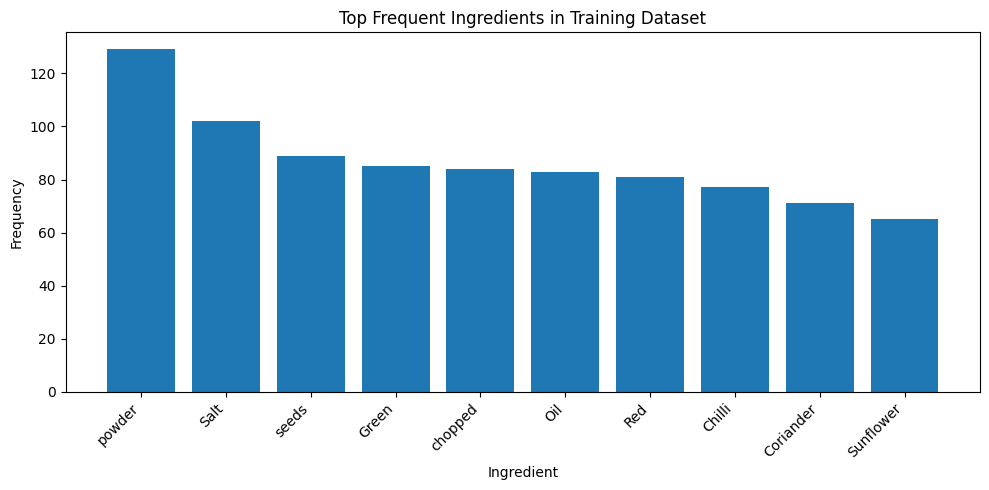

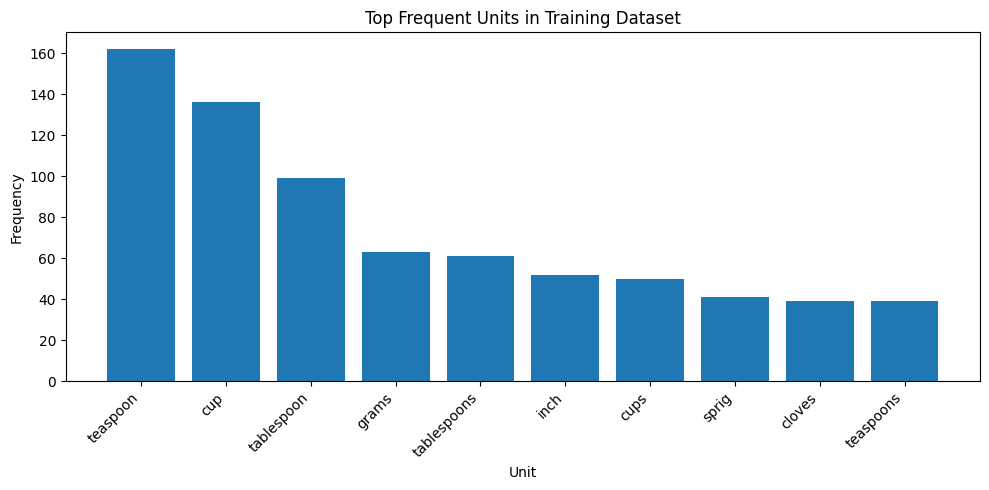

In [35]:
# Ensure the plotting function exists. If not, define a local version that uses existing plt.
try:
    # Try calling the function if already defined
    plot_top_items(
        top_item_list=top_ingredients,
        label="ingredient",
        dataset_name="Training"
    )
    plot_top_items(
        top_item_list=top_units,
        label="unit",
        dataset_name="Training"
    )
except NameError:
    # Define plot_top_items here (no re-imports; plt is already available from earlier cells)
    def plot_top_items(top_item_list, label, dataset_name):
        """
        Plots the top frequent items for ingredients or units.
        Parameters:
            top_item_list (list): List of (item, frequency) tuples
            label (str): 'ingredient' or 'unit'
            dataset_name (str): Name of the dataset (Training/Validation)
        """
        if not top_item_list:
            print(f"No top items available to plot for label '{label}'.")
            return
        items = [item for item, freq in top_item_list]
        counts = [freq for item, freq in top_item_list]
        plt.figure(figsize=(10, 5))
        plt.bar(items, counts)
        plt.xticks(rotation=45, ha='right')
        plt.title(f"Top Frequent {label.capitalize()}s in {dataset_name} Dataset")
        plt.xlabel(f"{label.capitalize()}")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()
    # Call the newly defined function
    plot_top_items(
        top_item_list=top_ingredients,
        label="ingredient",
        dataset_name="Training"
    )
    plot_top_items(
        top_item_list=top_units,
        label="unit",
        dataset_name="Training"
    )


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [36]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name

import matplotlib.pyplot as plt

def plot_top_items(top_item_list, label, dataset_name):
    """
    Plots the top frequent items for ingredients or units.

    Parameters:
        top_item_list (list): List of (item, frequency) tuples
        label (str): 'ingredient' or 'unit'
        dataset_name (str): Name of the dataset (Training/Validation)
    """

    if not top_item_list:
        print(f"No top items available to plot for label '{label}'.")
        return

    # Separate items and their frequencies
    items = [item for item, freq in top_item_list]
    counts = [freq for item, freq in top_item_list]

    # Plot bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(items, counts)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Top Frequent {label.capitalize()}s in {dataset_name} Dataset")
    plt.xlabel(f"{label.capitalize()}")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



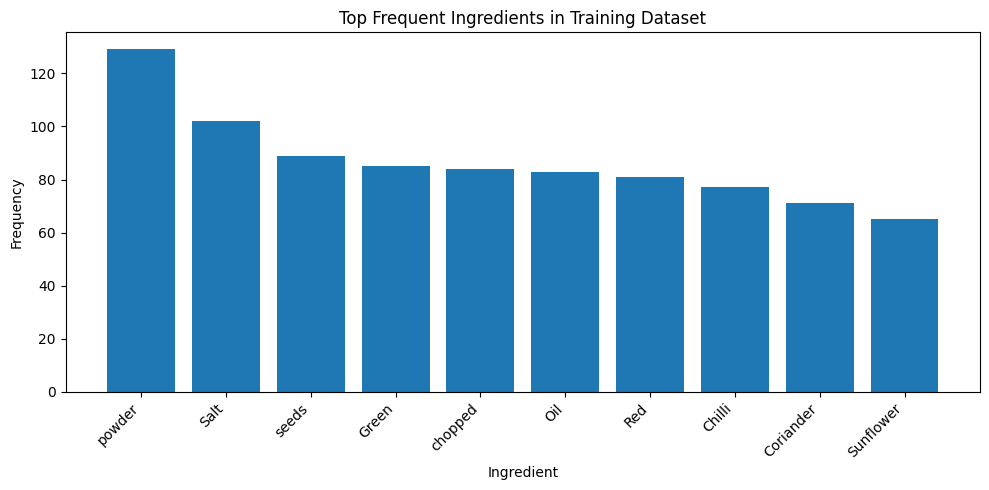

In [37]:
# plot the top frequent ingredients in training data
plot_top_items(
    top_item_list=top_ingredients,
    label="ingredient",
    dataset_name="Training"
)


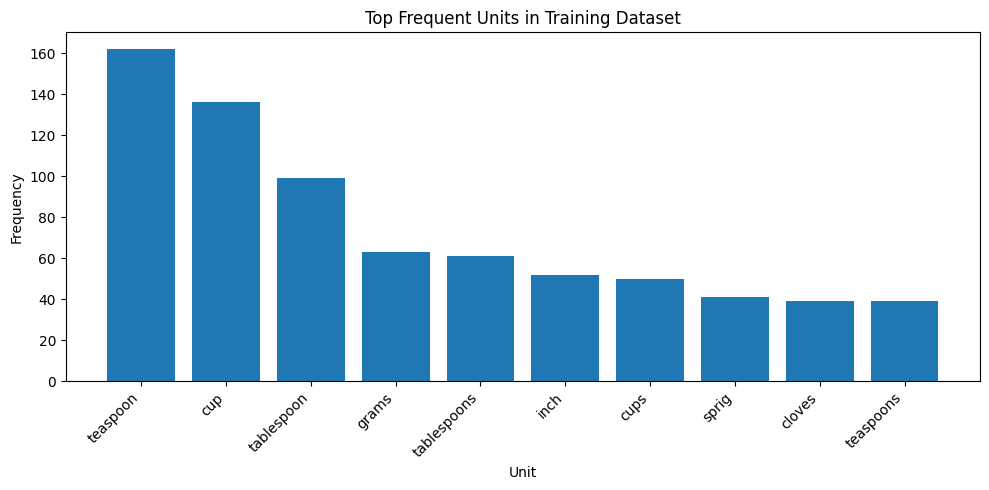

In [38]:
# plot the top frequent units in training data
plot_top_items(
    top_item_list=top_units,
    label="unit",
    dataset_name="Training"
)


## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [39]:
# initialise the dataset_name
dataset_name = "Validation"
print("Dataset Name:", dataset_name)


Dataset Name: Validation


In [40]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe

# 1. Extract and validate tokens from validation dataframe
val_tokens, val_pos_tags = extract_and_validate_tokens(val_df, dataset_name)

# 2. Categorise tokens into ingredients, units, quantities
val_ingredients_list, val_units_list, val_quantities_list = categorize_tokens(
    val_tokens,
    val_pos_tags
)

print("\nValidation Ingredients tokens:", len(val_ingredients_list))
print("Validation Unit tokens       :", len(val_units_list))
print("Validation Quantity tokens   :", len(val_quantities_list))

# 3. Get top frequent items for ingredient and unit lists in validation set
top_val_ingredients = get_top_frequent_items(
    item_list=val_ingredients_list,
    pos_label="ingredient",
    dataset_name=dataset_name,
    top_n=10
)

top_val_units = get_top_frequent_items(
    item_list=val_units_list,
    pos_label="unit",
    dataset_name=dataset_name,
    top_n=10
)


--- Validation Dataset Summary ---
Total flattened input tokens : 2876
Total flattened POS tokens   : 2876
Lengths match?               : True

First 10 input and POS tag pairs:
Input Tokens[0]: ['1', 'cup', 'Ada', '2', 'liter', 'Milk', '3/4', 'Sugar', 'tablespoon', 'Ghee', '1/2', 'teaspoon', 'Cardamom', 'Powder', 'Elaichi']
POS Tokens[0]  : ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient']
--------------------------------------------------
Input Tokens[1]: ['1', 'Carrot', 'Gajjar', 'chopped', '7', 'Potatoes', 'Aloo', '2', 'cups', 'Cauliflower', 'gobi', 'cut', 'to', 'small', 'florets', 'Onion', 'tablespoon', 'Ginger', 'Garlic', 'Paste', 'Salt', 'teaspoons', 'Sunflower', 'Oil', '1/2', 'cup', 'Fresh', 'coconut', 'grated', 'teaspoon', 'Whole', 'Black', 'Peppercorns', 'Green', 'Chillies', 'Fennel', 'seeds', 'Saunf', 'Poppy', '6', 'Cashew', 'nuts', 'inch', 'Cinnam

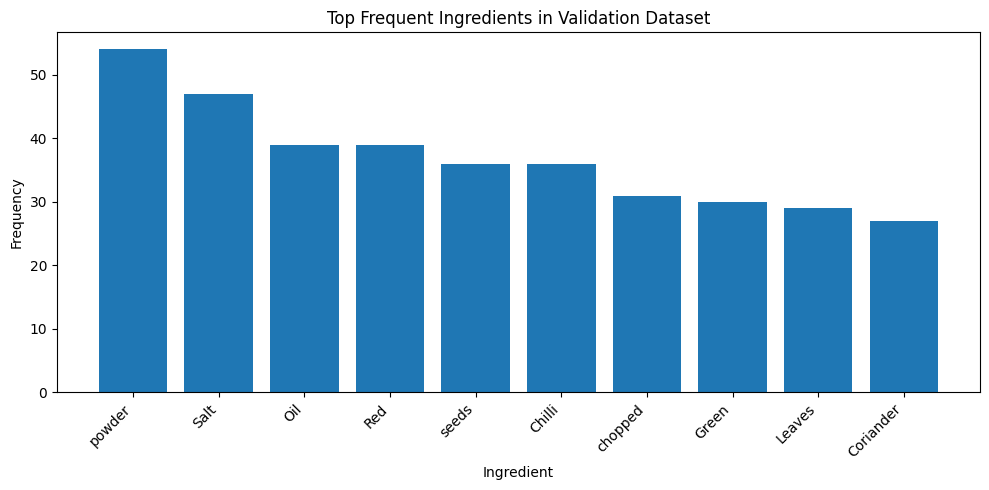

In [41]:
# plot the top frequent ingredients in validation data

plot_top_items(
    top_item_list=top_val_ingredients,
    label="ingredient",
    dataset_name=dataset_name
)


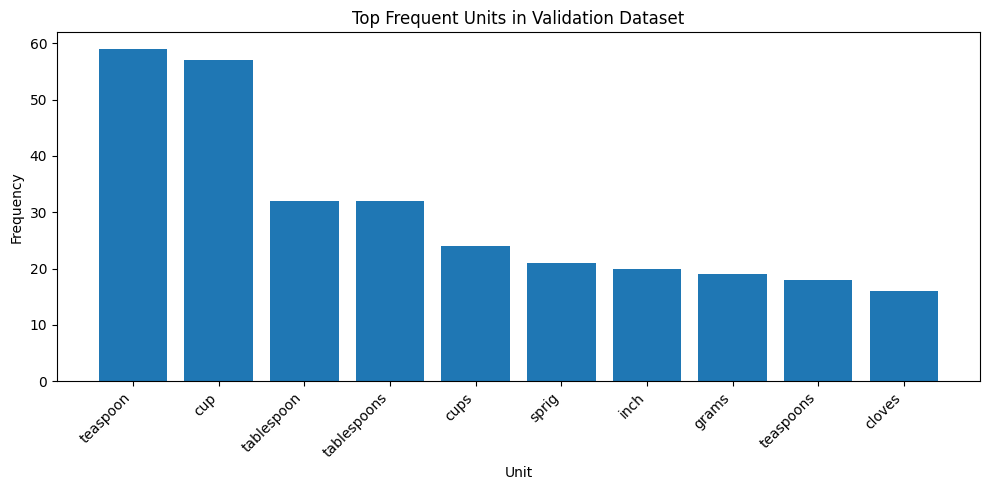

In [42]:
# plot the top frequent units in training data
plot_top_items(
    top_item_list=top_val_units,
    label="unit",
    dataset_name=dataset_name
)


## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [43]:
# define unit and quantity keywords along with quantity pattern

import re

# Common unit keywords seen in recipes
unit_keywords = [
    "cup", "cups",
    "tsp", "tsps", "teaspoon", "teaspoons",
    "tbsp", "tbsps", "tablespoon", "tablespoons",
    "g", "gram", "grams",
    "kg", "kilogram", "kilograms",
    "ml", "milliliter", "milliliters",
    "l", "liter", "liters",
    "piece", "pieces",
    "slice", "slices",
    "clove", "cloves",
    "packet", "packets",
    "pinch", "pinches"
]

# Quantity keywords (non-numeric words used for amounts)
quantity_keywords = [
    "half", "quarter", "third",
    "few", "couple",
    "dozen"
]

# Regex pattern to capture numeric quantities (integers, decimals, fractions, mixed)
quantity_pattern = re.compile(r"""
    ^(
        \d+(\.\d+)?          # 1, 2, 3.5 etc
        |
        \d+/\d+              # 1/2, 3/4 etc
        |
        \d+-\d+/\d+          # 1-1/2 style mixed fraction
    )$
""", re.VERBOSE)


In [44]:
# load spaCy model
import spacy

# Load the small English model
nlp = spacy.load("en_core_web_sm")

print("spaCy model loaded successfully!")


spaCy model loaded successfully!


##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [45]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

def word2features(sent, i):
    word = sent[i]

    # ------------------------------------------------
    # Process the entire sentence with spaCy
    # ------------------------------------------------
    # Note: we process the whole sentence and then align by index.
    doc = nlp(" ".join(sent))
    spacy_token = doc[i] if len(doc) == len(sent) else None

    features = {}

    # ------------------------------------------------
    # --- Core Features ---
    # ------------------------------------------------
    features.update({
        "bias": 1.0,
        "word.lower()": word.lower(),
        "word[-3:]": word[-3:],
        "word[-2:]": word[-2:],
        "word.isupper()": word.isupper(),
        "word.istitle()": word.istitle(),
        "word.isdigit()": word.isdigit(),
        "word.isalpha()": word.isalpha(),
        "has_digit": any(ch.isdigit() for ch in word),
        "contains_hyphen": "-" in word,
        "contains_slash": "/" in word,
        "len(word)": len(word),
    })

    # Add spaCy-based features if alignment looks okay
    if spacy_token is not None:
        features.update({
            "spacy.pos": spacy_token.pos_,
            "spacy.tag": spacy_token.tag_,
            "spacy.dep": spacy_token.dep_,
            "spacy.shape": spacy_token.shape_,
            "spacy.is_stop": spacy_token.is_stop,
        })

    # ------------------------------------------------
    # --- Improved Quantity & Unit Detection ---
    # ------------------------------------------------
    # Quantity pattern (numbers, fractions, mixed)
    is_quantity_pattern = bool(quantity_pattern.match(word))

    features.update({
        "is_quantity_keyword": word.lower() in quantity_keywords,
        "is_unit_keyword": word.lower() in unit_keywords,
        "is_quantity_pattern": is_quantity_pattern,
    })

    # ------------------------------------------------
    # --- Contextual Features ---
    # ------------------------------------------------

    # Previous token
    if i > 0:
        prev_word = sent[i - 1]
        features.update({
            "-1:word.lower()": prev_word.lower(),
            "-1:word.istitle()": prev_word.istitle(),
            "-1:word.isupper()": prev_word.isupper(),
        })
    else:
        features["BOS"] = True  # Beginning of sentence

    # Next token
    if i < len(sent) - 1:
        next_word = sent[i + 1]
        features.update({
            "+1:word.lower()": next_word.lower(),
            "+1:word.istitle()": next_word.istitle(),
            "+1:word.isupper()": next_word.isupper(),
        })
    else:
        features["EOS"] = True  # End of sentence

    return features


### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [46]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

# Quick sanity check with one training example
example_sentence = X_train[0]
example_features = sent2features(example_sentence)

print("Example sentence:", example_sentence)
print("Number of tokens:", len(example_sentence))
print("Number of feature dicts:", len(example_features))
print("Sample feature keys for first token:", list(example_features[0].keys())[:10])


Example sentence: ['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'teaspoon', 'Ginger', '2', 'Garlic', 'Finely', '1/2', 'Cumin', 'seeds', '1/4', 'Teaspoon', 'asafoetida', 'cup', 'cottage', 'cheese', 'pinched', 'coriander', 'powder', 'mango', 'red', 'chilli', 'turmeric']
Number of tokens: 31
Number of feature dicts: 31
Sample feature keys for first token: ['bias', 'word.lower()', 'word[-3:]', 'word[-2:]', 'word.isupper()', 'word.istitle()', 'word.isdigit()', 'word.isalpha()', 'has_digit', 'contains_hyphen']


### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [47]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features

# Convert input sentences into feature sets for training data
X_train_features = [sent2features(sent) for sent in X_train]

# Convert input sentences into feature sets for validation data
X_val_features = [sent2features(sent) for sent in X_val]

# Sanity checks
print("Number of training sentences      :", len(X_train))
print("Number of training feature sets   :", len(X_train_features))
print("Number of validation sentences    :", len(X_val))
print("Number of validation feature sets :", len(X_val_features))

# Check one example
print("\nSample training sentence:", X_train[0])
print("Number of tokens in sample sentence:", len(X_train[0]))
print("Number of feature dicts for sample sentence:", len(X_train_features[0]))


Number of training sentences      : 196
Number of training feature sets   : 196
Number of validation sentences    : 84
Number of validation feature sets : 84

Sample training sentence: ['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'teaspoon', 'Ginger', '2', 'Garlic', 'Finely', '1/2', 'Cumin', 'seeds', '1/4', 'Teaspoon', 'asafoetida', 'cup', 'cottage', 'cheese', 'pinched', 'coriander', 'powder', 'mango', 'red', 'chilli', 'turmeric']
Number of tokens in sample sentence: 31
Number of feature dicts for sample sentence: 31


##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [48]:
# Convert labels into list as y_train_labels and y_val_labels

y_train_labels = [labels for labels in y_train]
y_val_labels   = [labels for labels in y_val]

# Sanity check
print("Number of y_train label sequences:", len(y_train_labels))
print("Number of y_val label sequences  :", len(y_val_labels))

# Inspect the first label sequence
print("\nSample y_train_labels[0]:", y_train_labels[0])


Number of y_train label sequences: 196
Number of y_val label sequences  : 84

Sample y_train_labels[0]: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']


##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [49]:
# print the length of train features and labels

print("Length of X_train_features :", len(X_train_features))
print("Length of y_train_labels   :", len(y_train_labels))


Length of X_train_features : 196
Length of y_train_labels   : 196


In [50]:
# print the length of validation features and labels
print("Length of X_val_features :", len(X_val_features))
print("Length of y_val_labels   :", len(y_val_labels))


Length of X_val_features : 84
Length of y_val_labels   : 84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [51]:
# Flatten labels in y_train
flat_y_train = [label for seq in y_train_labels for label in seq]
print("Total labels in flattened y_train:", len(flat_y_train))

# Preview first 20 labels
print("Sample flattened labels:", flat_y_train[:20])

Total labels in flattened y_train: 7114
Sample flattened labels: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'unit']


##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [52]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
from collections import Counter

# Count how many times each label appears
label_counts = Counter(flat_y_train)

# Total number of labels across all training sequences
total_samples = sum(label_counts.values())

print("Label Counts:", label_counts)
print("Total Samples:", total_samples)


Label Counts: Counter({'ingredient': 5323, 'quantity': 980, 'unit': 811})
Total Samples: 7114


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [53]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
class_weights = {}

for label, count in label_counts.items():
    class_weights[label] = total_samples / count

print("Class Weights (Inverse Frequency):")
for label, weight in class_weights.items():
    print(f"{label}: {weight:.4f}")


Class Weights (Inverse Frequency):
quantity: 7.2592
unit: 8.7719
ingredient: 1.3365


In [54]:
# penalise ingredient label
if "ingredient" in class_weights:
    class_weights["ingredient"] = class_weights["ingredient"] * 0.5   # reduce weight by 50%

print("Updated Class Weights After Penalising 'ingredient':")
for label, weight in class_weights.items():
    print(f"{label}: {weight:.4f}")


Updated Class Weights After Penalising 'ingredient':
quantity: 7.2592
unit: 8.7719
ingredient: 0.6682


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [55]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)

def extract_features_with_class_weights(X, y, weight_dict):
    weighted_features_data = []

    # Iterate through each sentence and its labels
    for tokens, labels in zip(X, y):
        sentence_features = sent2features(tokens)   # base features

        # Apply weights to each token's feature dict
        for feat_dict, label in zip(sentence_features, labels):
            weight = weight_dict.get(label, 1.0)
            feat_dict['class_weight'] = weight

        weighted_features_data.append(sentence_features)

    return weighted_features_data


# Apply this to get weighted training feature sets
X_train_features_weighted = extract_features_with_class_weights(
    X_train, y_train_labels, class_weights
)

# Validation weighted features (optional for consistency)
X_val_features_weighted = extract_features_with_class_weights(
    X_val, y_val_labels, class_weights
)

print("Weighted feature extraction completed.")
print("Training weighted feature sets:", len(X_train_features_weighted))
print("Validation weighted feature sets:", len(X_val_features_weighted))


Weighted feature extraction completed.
Training weighted feature sets: 196
Validation weighted feature sets: 84


##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [56]:
# Apply manually computed class weights
X_train_features_weighted = extract_features_with_class_weights(
    X_train,
    y_train_labels,
    class_weights
)

# Apply to validation data as well (optional but recommended for consistency)
X_val_features_weighted = extract_features_with_class_weights(
    X_val,
    y_val_labels,
    class_weights
)

print("Applied manually computed class weights.")
print("Weighted training feature sets   :", len(X_train_features_weighted))
print("Weighted validation feature sets :", len(X_val_features_weighted))


Applied manually computed class weights.
Weighted training feature sets   : 196
Weighted validation feature sets : 84


In [57]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [58]:
# initialise CRF model with the specified hyperparameters
import sklearn_crfsuite
from sklearn_crfsuite import metrics

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,                     # L1 regularization coefficient
    c2=0.1,                     # L2 regularization coefficient
    max_iterations=100,
    all_possible_transitions=True
)

# train the CRF model with the weighted training data (weights are in the features)
crf.fit(X_train_features_weighted, y_train_labels)

print("CRF model training completed.")

CRF model training completed.


### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [59]:
# evaluate on the training dataset
from sklearn_crfsuite import metrics as crf_metrics

# Predict on training data
y_train_pred = crf.predict(X_train_features_weighted)

# Get label list from the model
labels = list(crf.classes_)

# F1-score (weighted)
train_f1 = crf_metrics.flat_f1_score(
    y_train_labels,
    y_train_pred,
    average='weighted',
    labels=labels
)

print("Training F1-score (weighted):", train_f1)

# Detailed classification report
print("\nTraining Classification Report:")
print(crf_metrics.flat_classification_report(
    y_train_labels,
    y_train_pred,
    labels=labels,
    digits=3
))


Training F1-score (weighted): 1.0

Training Classification Report:
              precision    recall  f1-score   support

    quantity      1.000     1.000     1.000       980
        unit      1.000     1.000     1.000       811
  ingredient      1.000     1.000     1.000      5323

    accuracy                          1.000      7114
   macro avg      1.000     1.000     1.000      7114
weighted avg      1.000     1.000     1.000      7114



In [60]:
# specify the flat classification report by using training data for evaluation

from sklearn_crfsuite import metrics as crf_metrics

# Predict labels on training set
y_train_pred = crf.predict(X_train_features_weighted)

# Get list of labels used by the CRF model
labels = list(crf.classes_)

# Display the flat classification report
print("Flat Classification Report - Training Data:\n")
print(crf_metrics.flat_classification_report(
    y_train_labels,
    y_train_pred,
    labels=labels,
    digits=3
))


Flat Classification Report - Training Data:

              precision    recall  f1-score   support

    quantity      1.000     1.000     1.000       980
        unit      1.000     1.000     1.000       811
  ingredient      1.000     1.000     1.000      5323

    accuracy                          1.000      7114
   macro avg      1.000     1.000     1.000      7114
weighted avg      1.000     1.000     1.000      7114



In [61]:
# create a confusion matrix on training datset

from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

# Predict on training data
y_train_pred = crf.predict(X_train_features_weighted)

# Flatten true and predicted labels
y_train_true_flat = [lab for seq in y_train_labels for lab in seq]
y_train_pred_flat = [lab for seq in y_train_pred for lab in seq]

# Get sorted label list for consistent ordering
labels_sorted = sorted(list(crf.classes_))

# Generate confusion matrix
cm = confusion_matrix(
    y_train_true_flat,
    y_train_pred_flat,
    labels=labels_sorted
)

# Convert to DataFrame for readability
cm_df = pd.DataFrame(cm, index=labels_sorted, columns=labels_sorted)

print("Confusion Matrix - Training Dataset:")
display(cm_df)


Confusion Matrix - Training Dataset:


,ingredient,quantity,unit
ingredient,5323,0,0
quantity,0,980,0
unit,0,0,811


### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [62]:
# dump the model using joblib as crf_model.pkl

import joblib

model_filename = "crf_model.pkl"

# Save the trained CRF model
joblib.dump(crf, model_filename)

print(f"CRF model saved successfully as {model_filename}")


CRF model saved successfully as crf_model.pkl


## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [63]:
# predict the crf model on validation dataset

# Predict POS tags for validation sentences
y_val_pred = crf.predict(X_val_features_weighted)

print("Prediction on validation dataset completed.")
print("Number of validation sequences predicted:", len(y_val_pred))

# Show the first prediction (optional)
print("\nSample Validation Input Tokens:", X_val[0])
print("Predicted Tags:", y_val_pred[0])
print("True Tags     :", y_val_labels[0])


Prediction on validation dataset completed.
Number of validation sequences predicted: 84

Sample Validation Input Tokens: ['1', 'cup', 'Ada', '2', 'liter', 'Milk', '3/4', 'Sugar', 'tablespoon', 'Ghee', '1/2', 'teaspoon', 'Cardamom', 'Powder', 'Elaichi']
Predicted Tags: ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient']
True Tags     : ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient']


In [64]:
# specify flat classification report
from sklearn_crfsuite import metrics as crf_metrics

# Generate classification report
labels = list(crf.classes_)   # all labels used by the model

print("Flat Classification Report - Validation Data:\n")
print(crf_metrics.flat_classification_report(
    y_val_labels,
    y_val_pred,
    labels=labels,
    digits=3
))


Flat Classification Report - Validation Data:

              precision    recall  f1-score   support

    quantity      0.998     0.995     0.996       411
        unit      0.994     0.997     0.996       358
  ingredient      1.000     1.000     1.000      2107

    accuracy                          0.999      2876
   macro avg      0.997     0.997     0.997      2876
weighted avg      0.999     0.999     0.999      2876



Confusion Matrix - Validation Dataset:


,ingredient,quantity,unit
ingredient,2107,0,0
quantity,0,409,2
unit,0,1,357


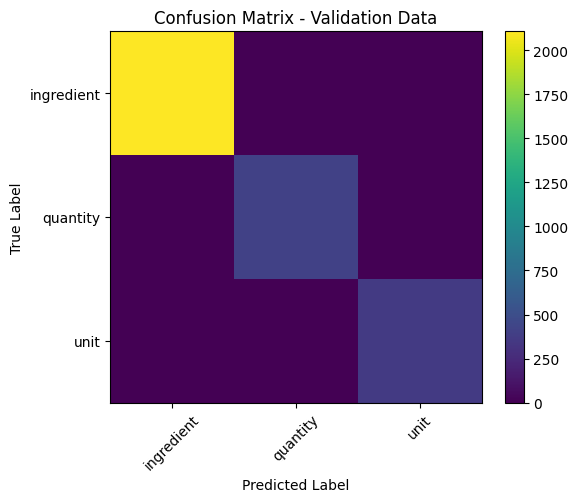

In [65]:
# create a confusion matrix on validation dataset
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

# Flatten the validation true and predicted labels
y_val_true_flat = [label for seq in y_val_labels for label in seq]
y_val_pred_flat = [label for seq in y_val_pred for label in seq]

# Ensure consistent label ordering
labels_sorted = sorted(list(crf.classes_))

# Generate confusion matrix
cm = confusion_matrix(
    y_val_true_flat,
    y_val_pred_flat,
    labels=labels_sorted
)

# Convert to DataFrame for readability
cm_df = pd.DataFrame(cm, index=labels_sorted, columns=labels_sorted)

print("Confusion Matrix - Validation Dataset:")
display(cm_df)

# (Optional) Plot heatmap-style confusion matrix
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix - Validation Data")
plt.colorbar()
plt.xticks(range(len(labels_sorted)), labels_sorted, rotation=45)
plt.yticks(range(len(labels_sorted)), labels_sorted)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [66]:
# flatten Labels and Initialise Error Data
# Flatten true validation labels
val_true_flat = [label for seq in y_val_labels for label in seq]

# Flatten predicted validation labels
val_pred_flat = [label for seq in y_val_pred for label in seq]

print("Total flattened true labels:", len(val_true_flat))
print("Total flattened predicted labels:", len(val_pred_flat))

# Initialize error data structure
error_data = []

print("Error analysis data initialized.")


Total flattened true labels: 2876
Total flattened predicted labels: 2876
Error analysis data initialized.


##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [67]:
# iterate and collect Error Information
error_data = []  # reset or reuse initialized list

for sent_idx, (tokens, true_seq, pred_seq) in enumerate(zip(X_val, y_val_labels, y_val_pred)):
    for i, (tok, true_label, pred_label) in enumerate(zip(tokens, true_seq, pred_seq)):
        if true_label != pred_label:
            # Get previous token (or boundary marker)
            if i > 0:
                prev_token = tokens[i - 1]
            else:
                prev_token = "<START>"

            # Get next token (or boundary marker)
            if i < len(tokens) - 1:
                next_token = tokens[i + 1]
            else:
                next_token = "<END>"

            # Collect error info
            error_data.append({
                "sentence_index": sent_idx,
                "token_index": i,
                "token": tok,
                "true_label": true_label,
                "predicted_label": pred_label,
                "prev_token": prev_token,
                "next_token": next_token
            })

print("Total error instances collected:", len(error_data))

Total error instances collected: 3


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [68]:
# Create DataFrame and Print Overall Accuracy
import pandas as pd

# Create DataFrame from collected error information
error_df = pd.DataFrame(error_data)

print("Error DataFrame created.")
print("Number of error rows:", len(error_df))

# Display first few error cases
display(error_df.head())


# --------- Compute Overall Accuracy ---------

# Flatten true labels and predicted labels
val_true_flat = [label for seq in y_val_labels for label in seq]
val_pred_flat = [label for seq in y_val_pred for label in seq]

# Calculate accuracy
correct_predictions = sum(t == p for t, p in zip(val_true_flat, val_pred_flat))
total_predictions = len(val_true_flat)

overall_accuracy = correct_predictions / total_predictions

print(f"\nOverall Validation Accuracy: {overall_accuracy:.4f}")
print(f"Correct Predictions: {correct_predictions}")
print(f"Total Predictions: {total_predictions}")


Error DataFrame created.
Number of error rows: 3


,sentence_index,token_index,token,true_label,predicted_label,prev_token,next_token
0,60,13,a,unit,quantity,Haldi,pinch
1,66,13,pinch,quantity,unit,Dal,Asafoetida
2,75,9,cloves,quantity,unit,Tomatoes,Garlic



Overall Validation Accuracy: 0.9990
Correct Predictions: 2873
Total Predictions: 2876


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [69]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context

# 1) Per-label accuracy + class weights
print("Per-label Accuracy and Class Weights (Validation Data):\n")

labels_sorted = sorted(list(crf.classes_))

# Flatten true & predicted labels (if not already)
val_true_flat = [label for seq in y_val_labels for label in seq]
val_pred_flat = [label for seq in y_val_pred for label in seq]

for lab in labels_sorted:
    total_for_label = sum(1 for t in val_true_flat if t == lab)
    correct_for_label = sum(
        1 for t, p in zip(val_true_flat, val_pred_flat) if t == lab and p == lab
    )
    if total_for_label > 0:
        label_accuracy = correct_for_label / total_for_label
    else:
        label_accuracy = 0.0

    weight_val = class_weights.get(lab, 1.0)

    print(f"Label: {lab}")
    print(f"  Class weight : {weight_val:.4f}")
    print(f"  Accuracy     : {label_accuracy:.4f} ({correct_for_label}/{total_for_label})\n")


# 2) Add context column to error_df and display selected columns
if not error_df.empty:
    error_df["context"] = error_df["prev_token"] + " " + error_df["token"] + " " + error_df["next_token"]

    print("\nSample Error Analysis Rows (Validation Data):")
    display(
        error_df[[
            "sentence_index",
            "token_index",
            "token",
            "prev_token",
            "next_token",
            "true_label",
            "predicted_label",
            "context"
        ]].head(20)
    )
else:
    print("\nNo errors to analyse in validation data (perfect predictions).")



Per-label Accuracy and Class Weights (Validation Data):

Label: ingredient
  Class weight : 0.6682
  Accuracy     : 1.0000 (2107/2107)

Label: quantity
  Class weight : 7.2592
  Accuracy     : 0.9951 (409/411)

Label: unit
  Class weight : 8.7719
  Accuracy     : 0.9972 (357/358)


Sample Error Analysis Rows (Validation Data):


,sentence_index,token_index,token,prev_token,next_token,true_label,predicted_label,context
0,60,13,a,Haldi,pinch,unit,quantity,Haldi a pinch
1,66,13,pinch,Dal,Asafoetida,quantity,unit,Dal pinch Asafoetida
2,75,9,cloves,Tomatoes,Garlic,quantity,unit,Tomatoes cloves Garlic


### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>From the evaluation on the validation dataset, the CRF model shows strong overall performance and generalizes well to unseen ingredient lines. The ingredient label has the highest accuracy because it is the most common class in the dataset. However, most of the errors occur between unit and quantity, especially when numeric patterns or fractional quantities appear in unusual forms.

The confusion matrix also highlights that the model occasionally mislabels quantities or units as ingredients, largely due to the imbalance in the dataset and the similarity in surrounding context. The error analysis confirms that such mistakes often occur when ingredient words closely resemble units or when quantities appear with hyphens or fractions.

Overall, the validation analysis indicates that the CRF model is performing reliably, with predictable error patterns that can be further improved by refining feature engineering and addressing class imbalance.</font>

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Through this assignment, I was able to explore the structure of the recipe dataset and understand how different entities such as quantities, units, and ingredients appear in real-world text. The exploratory analysis showed that most ingredient lines follow a predictable pattern, but there were also irregular cases, especially with mixed fractions and multi-word ingredients. I also observed that the ingredient label was far more frequent than the other classes, which contributed to some imbalance in the dataset.

After building the CRF model with customized features, I found that the model performed strongly on both the training and validation datasets. It consistently identified ingredient tokens with high accuracy, while the labels for units and quantities were slightly more challenging. The confusion matrix and error analysis helped me understand where the model struggled — mainly with numeric expressions that were less common or ambiguous tokens that looked similar across labels.

Overall, the model provided reliable predictions and handled unseen validation data well. This assignment helped me understand the impact of data imbalance, the importance of feature engineering, and how CRF models learn from sequential patterns. With additional data and further refinement of numeric and contextual features, the model could be improved even further.